In [1]:
import requests

lat = 35.678601  # 緯度
lon = 139.740286 # 経度

url = "http://cyberjapandata2.gsi.go.jp/general/dem/scripts/getelevation.php" \
       "?lon=%s&lat=%s&outtype=%s" %(lon, lat, "JSON")

resp = requests.get(url, timeout=10)
data = resp.json()

print(data["elevation"])

29.2


In [2]:
import osmnx as ox
import numpy as np

In [3]:
G = ox.graph_from_bbox(33.2217, 33.2388, 131.6758, 131.7305, network_type='walk', simplify=True, retain_all=False)


In [4]:
# add node elevations from a single raster file
# some nodes will be null because the single file does not cover the graph's extents
raster_path = "./sansa_elev.tif"
G = ox.elevation.add_node_elevations_raster(G, raster_path, cpus=1)

In [5]:
# add edge grades and their absolute values
G = ox.elevation.add_edge_grades(G, add_absolute=True)

In [6]:
import pandas as pd

In [7]:
# calculate the edges' absolute grades (and drop any infinite/null values)
grades = pd.Series([d["grade_abs"] for _, _, d in ox.get_undirected(G).edges(data=True)])
grades = grades.replace([np.inf, -np.inf], np.nan).dropna()

In [8]:
avg_grade = np.mean(grades)
place="Oita"
print("Average street grade in {} is {:.1f}%".format(place, avg_grade * 100))

med_grade = np.median(grades)
print("Median street grade in {} is {:.1f}%".format(place, med_grade * 100))

Average street grade in Oita is 0.2%
Median street grade in Oita is 0.0%


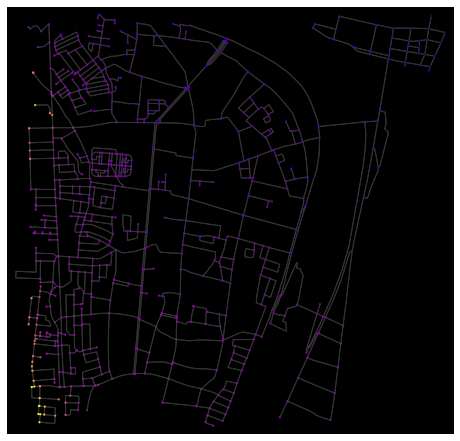

In [9]:
# get one color for each node, by elevation, then plot the network
nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
fig, ax = ox.plot_graph(G, node_color=nc, node_size=5, edge_color="#333333", bgcolor="k")

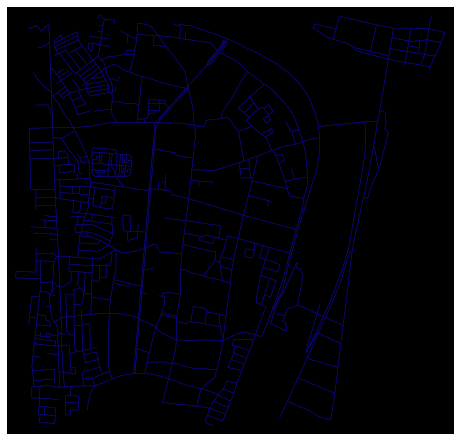

In [10]:
# get a color for each edge, by grade, then plot the network
ec = ox.plot.get_edge_colors_by_attr(G, "grade_abs", cmap="plasma", num_bins=1, equal_size=True)
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=0.5, node_size=0, bgcolor="k")

In [11]:
#G = ox.graph_from_bbox(33.2217, 33.2388, 131.6758, 131.7305, network_type='walk', simplify=True, retain_all=False)
origin = ox.distance.nearest_nodes(G,131.676,33.2218)
destination = ox.distance.nearest_nodes(G,131.7305,33.2387)
bbox = ox.utils_geo.bbox_from_point((33.23025,131.685),dist=1500)

In [12]:
def impedance(length,grade):
    penalty = grade**2
    return length*penalty
for _, _, _, data in G.edges(keys=True, data=True):
    data["impedance"] = impedance(data["length"], data["grade_abs"])
    data["rise"] = data["length"] * data["grade"]

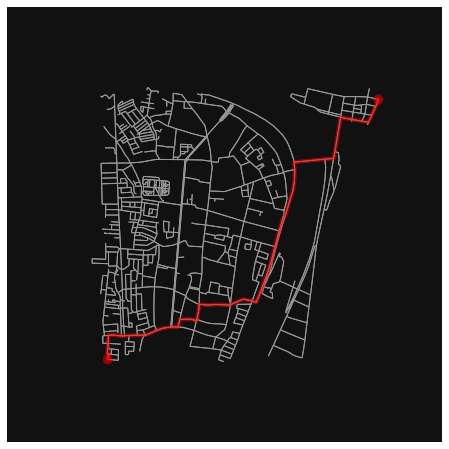

In [13]:
route_by_length = ox.shortest_path(G, origin, destination, weight="length")
fig, ax = ox.plot_graph_route(G, route_by_length, bbox=bbox, node_size=0)

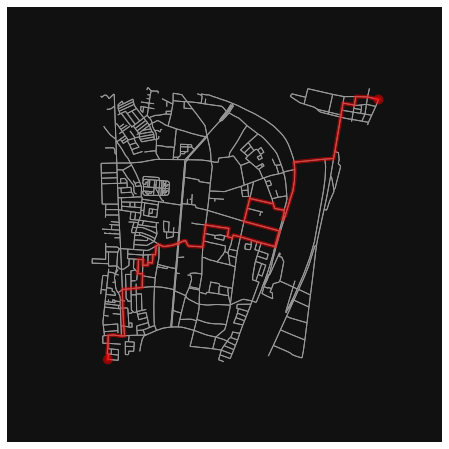

In [14]:
route_by_impedance = ox.shortest_path(G, origin, destination, weight="impedance")
fig, ax = ox.plot_graph_route(G, route_by_impedance, bbox=bbox, node_size=0)

In [15]:
def print_route_stats(route):
    route_grades = ox.utils_graph.get_route_edge_attributes(G, route, "grade_abs")
    msg = "The average grade is {:.1f}% and the max is {:.1f}%"
    print(msg.format(np.mean(route_grades) * 100, np.max(route_grades) * 100))

    route_rises = ox.utils_graph.get_route_edge_attributes(G, route, "rise")
    ascent = np.sum([rise for rise in route_rises if rise >= 0])
    descent = np.sum([rise for rise in route_rises if rise < 0])
    msg = "Total elevation change is {:.1f} meters: {:.0f} meter ascent and {:.0f} meter descent"
    print(msg.format(np.sum(route_rises), ascent, abs(descent)))

    route_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
    print("Total trip distance: {:,.0f} meters".format(np.sum(route_lengths)))

In [16]:
# stats of route minimizing length
print_route_stats(route_by_length)
# stats of route minimizing impedance (function of length and grade)
print_route_stats(route_by_impedance)

The average grade is 0.5% and the max is 7.8%
Total elevation change is -6.0 meters: 1 meter ascent and 7 meter descent
Total trip distance: 3,298 meters
The average grade is 0.3% and the max is 7.8%
Total elevation change is -5.8 meters: 0 meter ascent and 6 meter descent
Total trip distance: 4,576 meters


In [17]:
trip_times=[5,10,15,20,25]
travel_speed=4.5

In [18]:
G = ox.graph_from_bbox(33.2217, 33.2388, 131.6758, 131.7305, network_type='walk', simplify=True, retain_all=False)

In [19]:
gdf_nodes=ox.graph_to_gdfs(G,edges=False)
x,y=gdf_nodes['geometry'].unary_union.centroid.xy
center_node=ox.distance.nearest_nodes(G,x[0],y[0])
G=ox.project_graph(G)

In [20]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [21]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

In [22]:
import networkx as nx

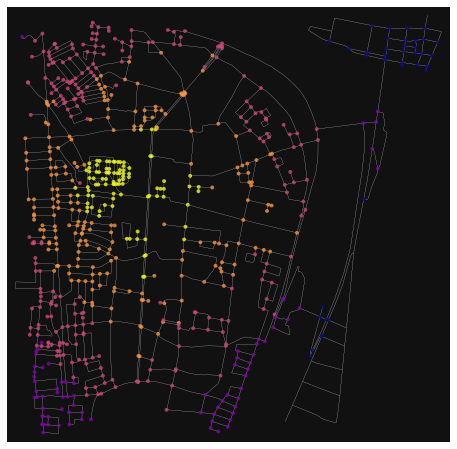

In [23]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

大磯

In [80]:
#大磯
G = ox.graph_from_bbox(35.2987, 35.3298, 139.299, 139.3257, network_type='walk', simplify=True, retain_all=False)

In [81]:
# add node elevations from a single raster file
# some nodes will be null because the single file does not cover the graph's extents
raster_path = "./oiso.tif"
G = ox.elevation.add_node_elevations_raster(G, raster_path, cpus=1)

In [82]:
# add edge grades and their absolute values
G = ox.elevation.add_edge_grades(G, add_absolute=True)

In [83]:
# calculate the edges' absolute grades (and drop any infinite/null values)
grades = pd.Series([d["grade_abs"] for _, _, d in ox.get_undirected(G).edges(data=True)])
grades = grades.replace([np.inf, -np.inf], np.nan).dropna()

In [87]:
avg_grade = np.mean(grades)
place="Oiso"
print("Average street grade in {} is {:.1f}%".format(place, avg_grade * 100))

med_grade = np.median(grades)
print("Median street grade in {} is {:.1f}%".format(place, med_grade * 100))

Average street grade in Oiso is 3.6%
Median street grade in Oiso is 1.3%


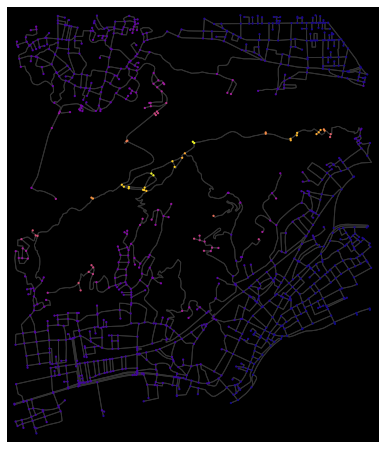

In [88]:
# get one color for each node, by elevation, then plot the network
nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
fig, ax = ox.plot_graph(G, node_color=nc, node_size=5, edge_color="#333333", bgcolor="k")

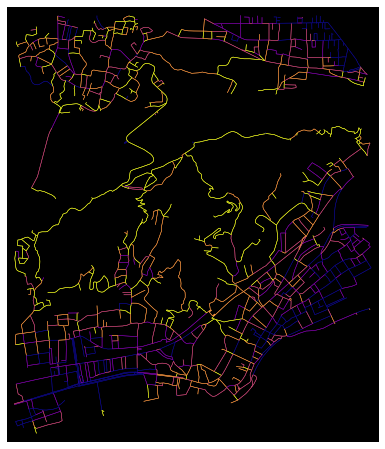

In [91]:
# get a color for each edge, by grade, then plot the network
ec = ox.plot.get_edge_colors_by_attr(G, "grade_abs", cmap="plasma", num_bins=5, equal_size=True)
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=0.5, node_size=0, bgcolor="k")

In [77]:
#G = ox.graph_from_bbox(33.2217, 33.2388, 131.6758, 131.7305, network_type='walk', simplify=True, retain_all=False)
#origin = ox.distance.nearest_nodes(G,139.300,35.30)
#destination = ox.distance.nearest_nodes(G,139.300,35.31)
bbox = ox.utils_geo.bbox_from_point((35.31,139.312),dist=1500)

津波避難ビル一覧
名称	所在地	海抜
1	モンメール大磯	高麗1丁目3番18号	  4.6m	3階廊下
2	戸塚ビル	高麗2丁目22番27号	  6.2m	3～5階各廊下
3	カルチャーBONDS平塚	平塚市平塚5丁目23番12号	  4.0m	3・4階フロア、屋上
4	神奈川県立大磯高等学校	東町2丁目9番1号	  3.9m	生徒在校中海側校舎3・4階各廊下  生徒不在時海側校舎3・4階、山側校舎3階
5	諸橋ビル	大磯2178番地17	  4.9m	屋上
6	プレステージ大磯	大磯1852番地2	  6.2m	屋上
7	町立ふれあい会館	大磯937番地4	  9.6m	3階大集会室
8	吉川ビル	大磯962番地	  6.9m	屋上
9	片野ビル	大磯971番地	  7.0m	屋上
10	汐彩のお宿大内館	大磯1083番地	10.8m	屋上
11	中南信用金庫本店	大磯1133番地1	10.3m	屋上
12	藤田眼科クリニックビル	大磯1188番地	12.4m	屋上
13	大磯町役場本庁舎	東小磯183番地	14.7m	3・4階各フロアおよび議場、5階議場傍聴室、屋上
14	大磯町消防本部	大磯1075番地	10.3m	屋上
15	アクアテラス大磯	西小磯292番地1	14.9m	3階廊下、屋上
16	サンキッズ大磯	東町1丁目13番33号	  6.0m	屋上
 
津波避難場所
 	名称	所在地	海抜  注意2	避難に使用する場所
1	学校法人聖ステパノ学園	大磯868番地	16～42m	運動場、広場
2	社会福祉法人 エリザベス・サンダース・ホーム	大磯1152番地	15～19m	運動場、広場
3	アクサ生命保険株式会社大磯研修センター	大磯1010番地	17～21m	研修所、体育館、敷地
4	大磯プリンスホテル	国府本郷546番地	17～20m	駐車場、テニス・フットサルコート(天候等により建物内の一部も使用可)
5	県立大磯城山公園  国府本郷576番地	 8～42m	園路、広場

In [67]:
import csv
hinansho_loc=[]
with open('oiso_hinansho_fxfy.csv', newline='') as csvfile:
    rows = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in rows:
        hinansho_loc+=[(row[0],row[3],row[4])]
        print(row[0],row[3],row[4])
print(hinansho_loc)

モンメール大磯 139.32545 35.32005
戸塚ビル 139.32458 35.32573
カルチャーBONDS平塚 139.33054 35.32660
神奈川県立大磯高等学校 141.66280 43.05806
諸橋ビル 139.32338 35.31623
プレステージ大磯 139.31801 35.31210
町立ふれあい会館 139.31609 35.31260
吉川ビル 139.31670 35.31168
片野ビル 139.31761 35.31142
汐彩のお宿大内館 139.31549 35.30810
中南信用金庫本店 139.31483 35.30883
藤田眼科クリニックビル 139.31151 35.30778
大磯町役場本庁舎 139.31151 35.30698
大磯町消防本部 139.31549 35.30810
アクアテラス大磯 139.29150 35.30342
サンキッズ大磯 141.66624 43.05996
学校法人聖ステパノ学園 139.31361 35.30960
社会福祉法人 エリザベス・サンダース・ホーム 139.31361 35.30960
アクサ生命保険株式会社大磯研修センター 139.31361 35.30960
大磯プリンスホテル 139.27904 35.30196
[('モンメール大磯', '139.32545', '35.32005'), ('戸塚ビル', '139.32458', '35.32573'), ('カルチャーBONDS平塚', '139.33054', '35.32660'), ('神奈川県立大磯高等学校', '141.66280', '43.05806'), ('諸橋ビル', '139.32338', '35.31623'), ('プレステージ大磯', '139.31801', '35.31210'), ('町立ふれあい会館', '139.31609', '35.31260'), ('吉川ビル', '139.31670', '35.31168'), ('片野ビル', '139.31761', '35.31142'), ('汐彩のお宿大内館', '139.31549', '35.30810'), ('中南信用金庫本店', '139.31483', '35.30883'), 

In [94]:
import copy


In [95]:
trip_times=[5,10,15,20,25]
travel_speed=4.5
meters_per_minute= travel_speed*1000/60

In [106]:
for _,_,_, data in G.edges(data=True,keys=True):
    data["time"] = data["length"]/meters_per_minute

In [107]:
iso_colors=ox.plot.get_colors(n=len(trip_times),cmap="plasma",start=0,return_hex=True)

In [103]:
hinansho_node={}
for i in hinansho_loc:
    hinansho_node[i]=ox.distance.nearest_nodes(G,float(i[1]),float(i[2]))

139.32545 35.32005
139.32458 35.32573
139.33054 35.3266
141.6628 43.05806
139.32338 35.31623
139.31801 35.3121
139.31609 35.3126
139.3167 35.31168
139.31761 35.31142
139.31549 35.3081
139.31483 35.30883
139.31151 35.30778
139.31151 35.30698
139.31549 35.3081
139.2915 35.30342
141.66624 43.05996
139.31361 35.3096
139.31361 35.3096
139.31361 35.3096
139.27904 35.30196


dict_values([1866729786, 4878723711, 4878723714, 2250665135, 6715734051, 482208314, 480738123, 3238187961, 482207891, 6715755730, 1865400630, 1962203731, 3060892890, 6715755730, 1831740007, 2250665135, 3060892898, 3060892898, 3060892898, 1831740007])

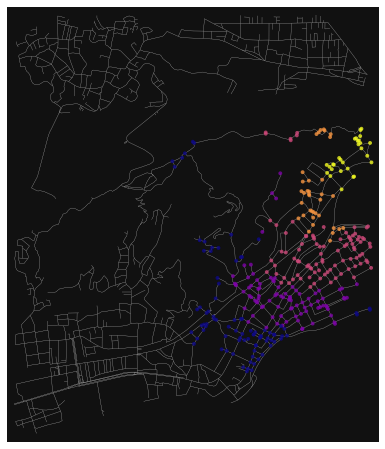

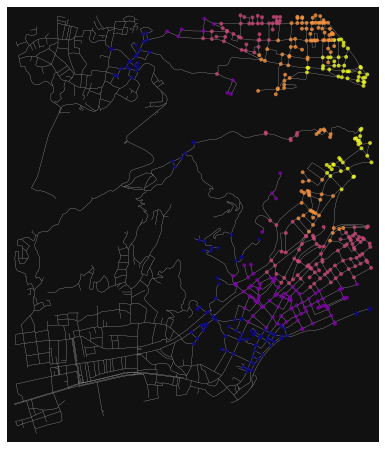

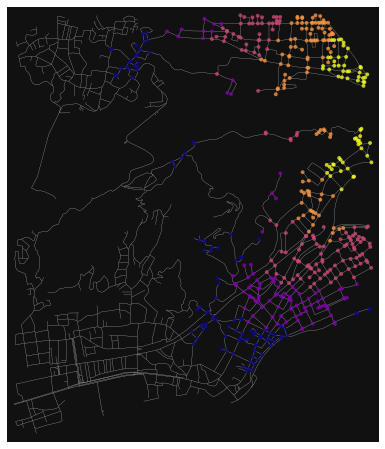

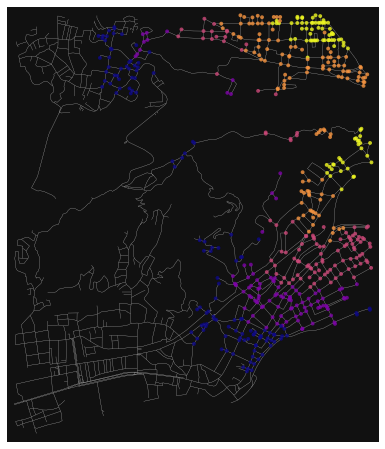

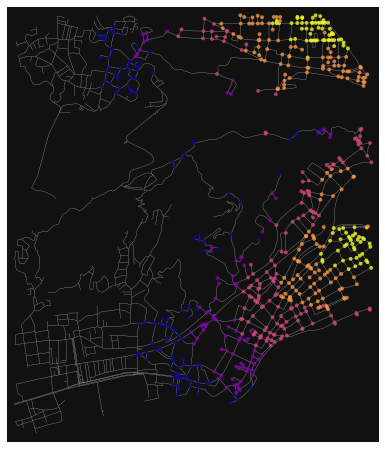

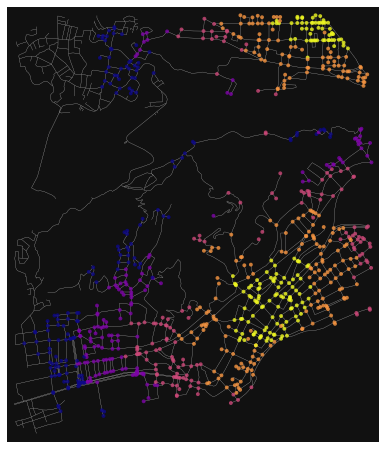

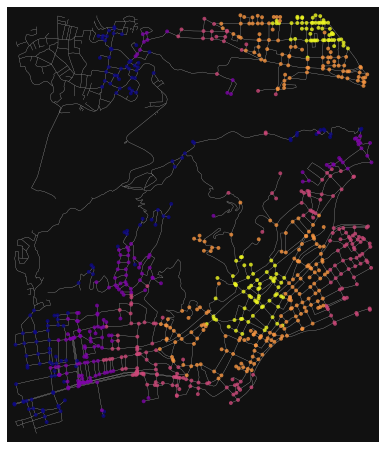

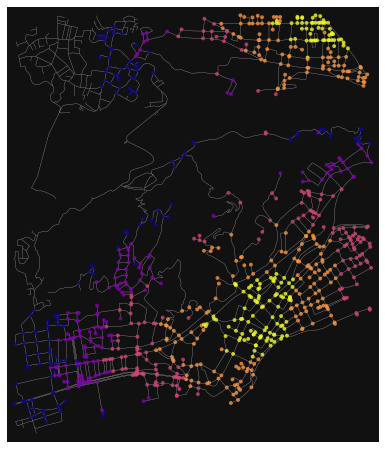

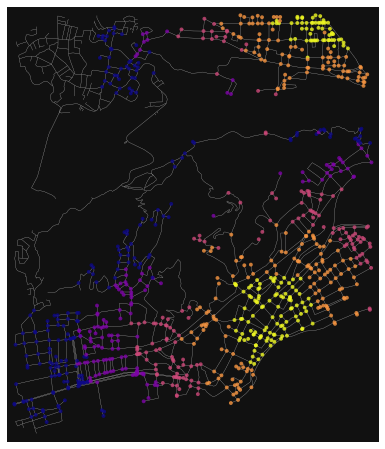

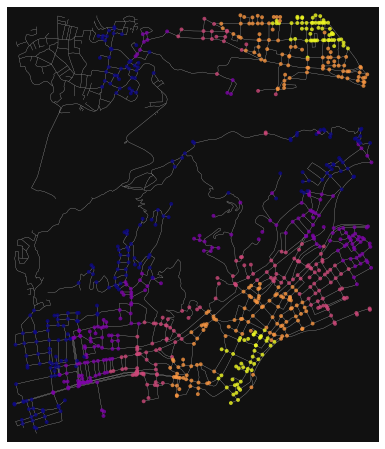

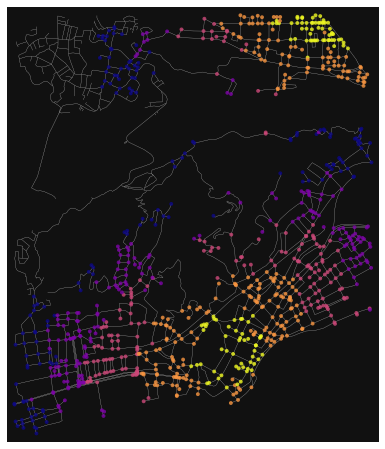

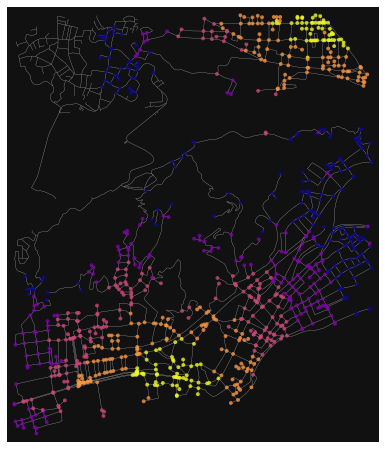

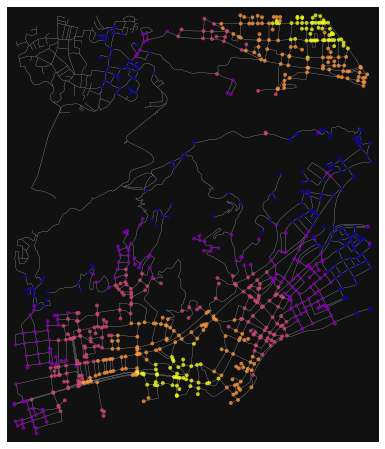

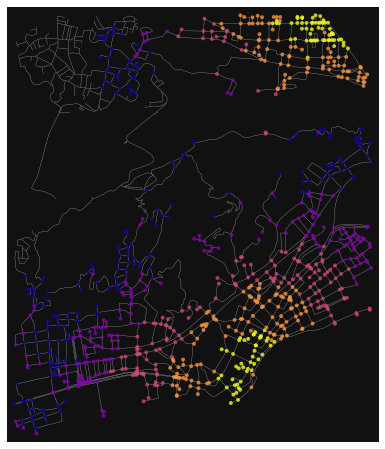

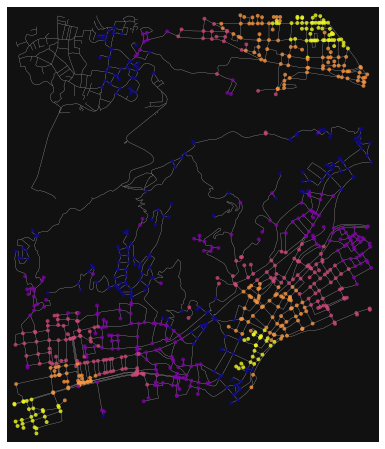

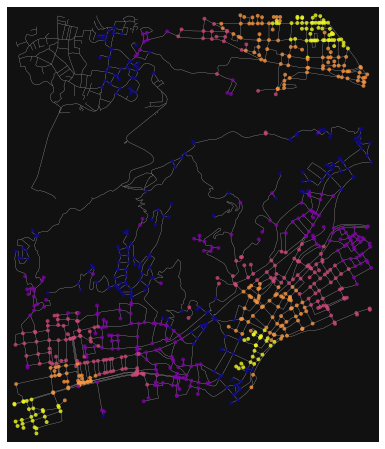

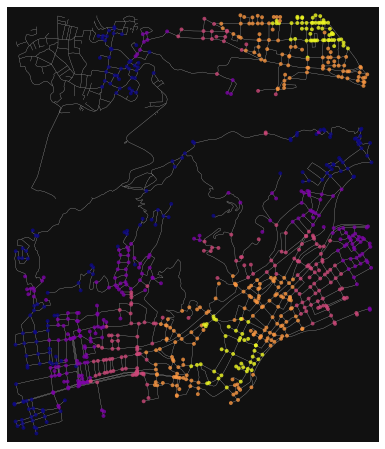

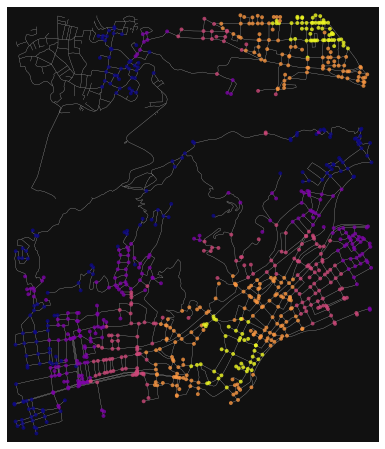

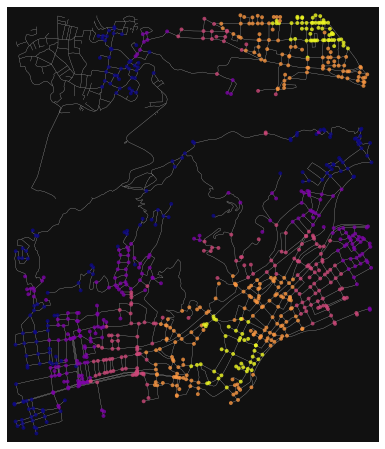

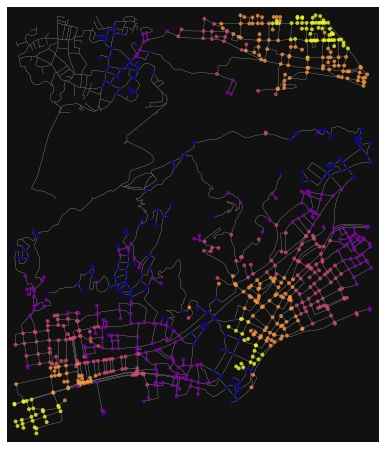

In [109]:
node_colors={}
for center_node in hinansho_node.values():
    for trip_time, color in zip(sorted(trip_times,reverse=True),iso_colors):
        subgraph = nx.ego_graph(G,center_node,radius=trip_time,distance="time")
        for node in subgraph.nodes():
            node_colors[node]=color
    nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
    ns = [15 if node in node_colors else 0 for node in G.nodes()]
    fig,ax=ox.plot_graph(G,
                         node_color=nc,
                         node_size=ns,
                         node_alpha=0.8,
                         edge_linewidth=0.2,
                         edge_color="#999999",
                        )

In [78]:
#G=ox.project_graph(G)

In [53]:
def impedance(length,grade):
    penalty = grade**2
    return length*penalty
for _, _, _, data in G.edges(keys=True, data=True):
    data["impedance"] = impedance(data["length"], data["grade_abs"])
    data["rise"] = data["length"] * data["grade"]

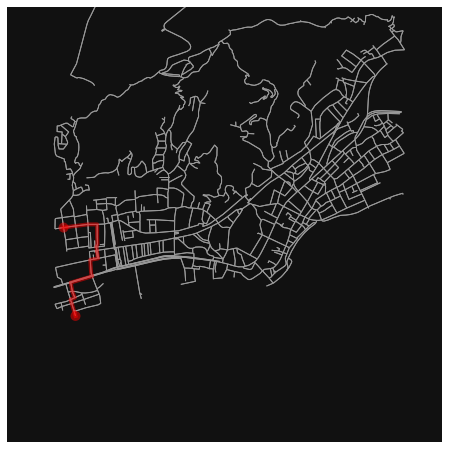

In [54]:
route_by_length = ox.shortest_path(G, origin, destination, weight="length")
fig, ax = ox.plot_graph_route(G, route_by_length, bbox=bbox, node_size=0)

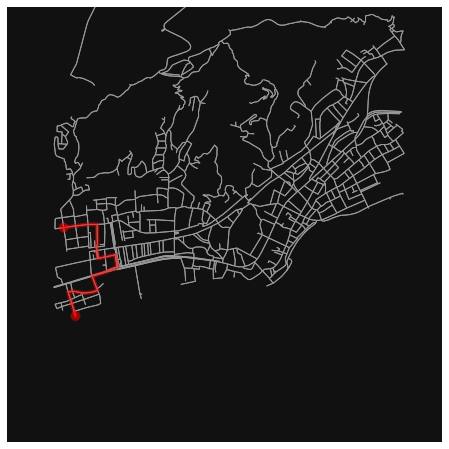

In [55]:
route_by_impedance = ox.shortest_path(G, origin, destination, weight="impedance")
fig, ax = ox.plot_graph_route(G, route_by_impedance, bbox=bbox, node_size=0)

In [56]:
def print_route_stats(route):
    route_grades = ox.utils_graph.get_route_edge_attributes(G, route, "grade_abs")
    msg = "The average grade is {:.1f}% and the max is {:.1f}%"
    print(msg.format(np.mean(route_grades) * 100, np.max(route_grades) * 100))

    route_rises = ox.utils_graph.get_route_edge_attributes(G, route, "rise")
    ascent = np.sum([rise for rise in route_rises if rise >= 0])
    descent = np.sum([rise for rise in route_rises if rise < 0])
    msg = "Total elevation change is {:.1f} meters: {:.0f} meter ascent and {:.0f} meter descent"
    print(msg.format(np.sum(route_rises), ascent, abs(descent)))

    route_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
    print("Total trip distance: {:,.0f} meters".format(np.sum(route_lengths)))

In [36]:
# stats of route minimizing length
print_route_stats(route_by_length)
# stats of route minimizing impedance (function of length and grade)
print_route_stats(route_by_impedance)

The average grade is 1.8% and the max is 21.8%
Total elevation change is 13.7 meters: 14 meter ascent and 1 meter descent
Total trip distance: 1,050 meters
The average grade is 1.4% and the max is 21.8%
Total elevation change is 13.8 meters: 14 meter ascent and 0 meter descent
Total trip distance: 1,350 meters


In [69]:
for eloc in hinansho_loc:
    origin = ox.distance.nearest_nodes(G,float(eloc[1]),float(eloc[2]))
    print(origin)
#    origin = ox.distance.nearest_nodes(G,139.300,35.30)
#    destination = ox.distance.nearest_nodes(G,139.300,35.31)

1866729786
4878723711
4878723714
2250665135
6715734051
482208314
480738123
3238187961
482207891
6715755730
1865400630
1962203731
3060892890
6715755730
1831740007
2250665135
3060892898
3060892898
3060892898
1831740007


国土数値情報の読み込み


In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [38]:
path_shp="./500m_mesh_suikei_2018_shape_44/500m_mesh_2018_44.shp"

In [39]:
gdf = gpd.read_file(path_shp)

In [40]:
gdf.head()

,MESH_ID,SHICODE,PTN_2015,HITOKU2020,GASSAN2020,PTN_2020,PT0_2020,PT1_2020,PT2_2020,PT3_2020,...,PTB_2050,PTC_2050,PTD_2050,PTE_2050,RTA_2050,RTB_2050,RTC_2050,RTD_2050,RTE_2050,geometry
0,493047591,44204,2.0030,*,493047593.0,1.8171,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,"POLYGON ((130.98750 33.04167, 130.98750 33.045..."
1,493047593,44204,62.0977,@,NaN,57.2280,59.0451,0.9241,2.9858,2.9181,...,12.2509,13.9033,8.6455,6.3344,6.9308,43.5946,49.4746,30.7649,22.5407,"POLYGON ((130.98750 33.04583, 130.98750 33.050..."
2,493047683,44204,5.0104,None,NaN,4.6440,4.6440,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,"POLYGON ((130.97500 33.05417, 130.97500 33.058..."
3,493047684,44204,33.0110,None,NaN,30.3303,30.3303,0.8651,2.9858,0.9727,...,6.1025,9.3617,5.8952,2.8816,6.8998,36.7393,56.3609,35.4913,17.3482,"POLYGON ((130.98125 33.05417, 130.98125 33.058..."
4,493047691,44204,1.0029,*,493047693.0,0.8701,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,"POLYGON ((130.98750 33.05000, 130.98750 33.054..."


<AxesSubplot:>

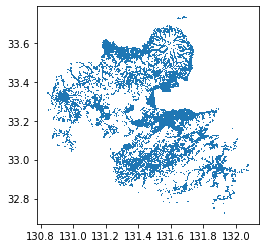

In [43]:
gdf.plot()

In [44]:
gdf_nodes

,y,x,street_count,highway,geometry
osmid,,,,,
653263632,33.229738,131.681599,3,NaN,POINT (131.68160 33.22974)
653263633,33.234265,131.682059,4,traffic_signals,POINT (131.68206 33.23426)
1430236183,33.238175,131.693862,4,NaN,POINT (131.69386 33.23817)
1430236216,33.223077,131.690953,3,NaN,POINT (131.69095 33.22308)
1430236218,33.224142,131.691108,3,NaN,POINT (131.69111 33.22414)
...,...,...,...,...,...
8906017887,33.235729,131.683745,1,NaN,POINT (131.68375 33.23573)
8906017889,33.235694,131.683709,4,crossing,POINT (131.68371 33.23569)
8906017890,33.235722,131.683544,1,NaN,POINT (131.68354 33.23572)
